In [1]:
import os
import pickle as pkl

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.model_selection import train_test_split

np.set_printoptions(suppress=True)

In [2]:
if os.path.exists("mnist_784_X_y.pkl"):
    X, y = pkl.load(open("mnist_784_X_y.pkl", 'rb'))
else:
    X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [3]:
X_test_reversed = np.flip(X_test, axis=1)
X_test_sorted = np.sort(X_test, axis=1)
X_test_normalized = X_test / 255.0
X_test_clipped = np.clip(X_test, a_min=0, a_max=200)
X_test_shift_no_1s = X_test[y_test!="1", :]
y_test_shift_no_1s = y_test[y_test!="1"]
X_test_shift_no_9s = X_test[y_test!="9", :]
y_test_shift_no_9s = y_test[y_test!="9"]

The centroid references always matched the label, but the counts of closest references did not match. Consider label 9 in our PCA. Very nearby are the centroids for 7 and 4. So in the cases 

In [4]:
class ReferenceSelector:
    def __init__(self):
        self.n_references = 0
        self.ref_labels = None

    def calculate_references(self, X: np.array, y: np.array):
        raise NotImplementedError()

In [5]:
class PCACentroids(ReferenceSelector):
    def __init__(self, n_components=2, lower_percentile_limit=0, upper_percentile_limit=0):
        super().__init__()
        self.n_components = n_components
        self.lower_percentile_limit = lower_percentile_limit
        self.upper_percentile_limit = upper_percentile_limit

    def calculate_references(self, X: np.array, y: np.array):
        # Fit PCA
        pca = PCA(n_components=self.n_components)
        X_pca = pca.fit_transform(X)

        # Find centroids for each label in PCA space
        n_labels = np.unique(y).shape[0]
        refs = [None] * n_labels
        labels = sorted(np.unique(y))
        self.n_references = len(labels)
        self.ref_labels = labels
        for i, label in enumerate(labels):
            filtered_X_pca = X_pca[y==label]
            if self.lower_percentile_limit != 0 or self.upper_percentile_limit != 0:
                lp = np.percentile(filtered_X_pca, self.lower_percentile_limit)
                up = np.percentile(filtered_X_pca, self.upper_percentile_limit)
                filtered_X_pca = filtered_X_pca[(lp < filtered_X_pca) & (filtered_X_pca < up)]
            refs[i] = filtered_X_pca.mean(axis=0)
        refs = np.array(refs)

        # Convert centroids back to raw space
        raw_refs = pca.inverse_transform(refs)

        return raw_refs

In [6]:
class PCAKMeans(ReferenceSelector):
    def __init__(self, n_clusters=8, n_components=2, kmeans_kwargs={}):
        super().__init__()
        self.n_clusters = n_clusters
        self.n_components = n_components
        self.kmeans_kwargs = kmeans_kwargs

    def calculate_references(self, X: np.array, y: np.array):
        self.n_references = self.n_clusters
        self.ref_labels = list(range(self.n_clusters))

        # Fit PCA first
        pca = PCA(n_components=self.n_components)
        X_pca = pca.fit_transform(X)

        # Find k-means clusters
        kmeans = KMeans(n_clusters=self.n_clusters, **self.kmeans_kwargs)
        kmeans.fit(X_pca)
        refs = kmeans.cluster_centers_
        
        # Convert centroids back to raw space
        raw_refs = pca.inverse_transform(refs)

        return raw_refs

In [7]:
class EmbeddingsAnalysis:
    distance_fns = {'euclidean': euclidean_distances, 'cosine': cosine_distances}

    def __init__(self, X, y=None, 
                 distance='cosine',
                 reference_selector: ReferenceSelector = PCACentroids(n_components=2)):
        if distance not in EmbeddingsAnalysis.distance_fns:
            raise ValueError(f"Distance not valid. Choose one of {list(EmbeddingsAnalysis.distance_fns.keys())}.")
        self.X = X
        self.y = y
        self.labels = sorted(np.unique(y))
        self.distance_method = EmbeddingsAnalysis.distance_fns[distance]
        self.plot_pca = None
        self.X_plot_pca = None
        self.refs_plot_pca = None
        self.X_ref_dists = None
        self.X_ref_closest = None

        print("Calculating references...", end=" ")
        self.refs = reference_selector.calculate_references(X, y)
        self.n_references = reference_selector.n_references
        self.ref_labels = reference_selector.ref_labels
        print("Done.")

        print("Calculating distances from data points to references...", end=" ")
        self.X_ref_dists = self.distance_method(self.X, self.refs)
        print("Done.")

        print("Finding closest reference for each data point...", end=" ")
        self.X_ref_closest = np.argmin(self.X_ref_dists, axis=1)
        print("Done.")

    def plot(self, X = None, y = None, n: int = 1000, show_references: bool = True, method: str = 'pca'):
        if self.X_plot_pca is None:
            print("Fitting PCA to data for plot for all data...", end=" ")
            # Fit PCA
            self.plot_pca = PCA(n_components=2)
            self.X_plot_pca = self.plot_pca.fit_transform(self.X)
            print("Done.")
        
        X_plot = self.X_plot_pca if X is None else self.plot_pca.transform(X)
        y_plot = self.y if y is None else y

        fig, ax = plt.subplots()
        
        if y_plot is not None:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], hue=y_plot[:n], s=20, ax=ax)
        else:
            sns.scatterplot(x=X_plot[:n, 0], y=X_plot[:n, 1], s=20, ax=ax)
        
        if show_references and self.refs is not None:
            if self.refs_plot_pca is None:
                self.refs_plot_pca = self.plot_pca.transform(self.refs)
            sns.scatterplot(x=self.refs_plot_pca[:, 0], y=self.refs_plot_pca[:, 1], color="black", marker="X", s=0, ax=ax)
            # centroid labels
            for i, ref_label in enumerate(self.ref_labels):
                plt.text(x=self.refs_plot_pca[i, 0], y=self.refs_plot_pca[i, 1], s=str(i), horizontalalignment='center', 
                        color='black', weight='bold')
    
    def plot_reference_distances(self, X = None, n: int = 1000):
        X_plot = self.X_ref_dists if X is None else self.distance_method(X, self.refs)
        
        return sns.displot(data=pd.melt(pd.DataFrame(X_plot[:n]), var_name="Reference index", value_name="Distance"),
                               x="Distance", col="Reference index", col_wrap=2, kind='kde', height=1, aspect=3)

    def plot_closest_references_by_label(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None: 
            n = len(X_plot)
        
        closest_ref_count_by_label = []
        for label in self.labels:
            closest_ref_count_by_label.append(np.bincount(X_plot[:n][y_plot[:n]==label], 
                                                          minlength=self.n_references))
        closest_ref_count_by_label = np.array(closest_ref_count_by_label)

        return sns.heatmap(closest_ref_count_by_label, annot=True, fmt=".0f", linewidth=1, linecolor='w').set(xlabel="Closest reference", ylabel="True label")
    
    def plot_closest_references(self, X = None, y = None, n: int = None):
        X_plot = self.X_ref_closest if X is None else np.argmin(self.distance_method(X, self.refs), axis=1)
        y_plot = self.y if X is None else y
        
        if n is None:
            n = len(X_plot)
        closest_ref_count = np.bincount(X_plot[:n], minlength=self.n_references)

        return sns.barplot(x=list(range(self.n_references)), y=closest_ref_count
                          ).set(xlabel="Reference index", ylabel="Closest count")

In [8]:
b = EmbeddingsAnalysis(X_train, y_train, distance='euclidean', reference_selector=PCACentroids(n_components=20))
print(b.labels)
print(b.refs.shape)

Calculating references... Done.
Calculating distances from data points to references... Done.
Finding closest reference for each data point... Done.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
(10, 784)


## Install whylogs

While the embeddings stuff hangs out on a branch, we need to upload the wheel or create a dev release.

In [10]:
%pip install -q ./whylogs-1.1.21-py3-none-any.whl[embeddings,whylabs]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 548.0/548.0 KB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.4/340.4 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.6 MB/s eta 0:00:00


### Embedding Logging

Here I use the `EmbeddingsAnalysis` to compute the reference matrix and labels. Just plug them into the `EmbeddingConfig` and use a `DeclarativeSchema` to give us an `EmbeddingMetric` for out logged data. Let's log the MNIST training data.

In [11]:
import whylogs as why
from whylogs.core.resolvers import MetricSpec, ResolverSpec
from whylogs.core.schema import DeclarativeSchema
from whylogs.experimental.core.metrics.embedding_metric import (
    DistanceFunction,
    EmbeddingConfig,
    EmbeddingMetric,
)

config = EmbeddingConfig(
    references=b.refs,
    labels=b.labels,
    distance_fn=DistanceFunction.euclidean,
)
schema = DeclarativeSchema([ResolverSpec(column_name="digits", metrics=[MetricSpec(EmbeddingMetric, config)])])
profile = why.log(row={"digits": X_test}, schema=schema)
view = profile.view()
column = view.get_column("digits")
summary = column.to_summary_dict()
for digit in [str(i) for i in range(10)]:
    mean = summary[f'embedding/{digit}_distance:distribution/mean']
    stddev = summary[f'embedding/{digit}_distance:distribution/stddev']
    print(f"{digit} distance: mean {mean}   stddev {stddev}")

0 distance: mean 2187.141655801724   stddev 203.77334471283987
1 distance: mean 2059.8602212668993   stddev 469.4735831642491
2 distance: mean 1992.0445862874203   stddev 229.22836662674615
3 distance: mean 1995.4869736463306   stddev 273.2394062165652
4 distance: mean 1975.553989765833   stddev 301.63881642563325
5 distance: mean 1909.8737682353667   stddev 251.25025999164887
6 distance: mean 2022.1356935316103   stddev 255.4575357111235
7 distance: mean 2012.5709735416726   stddev 344.84768332262973
8 distance: mean 1937.1825351038522   stddev 260.35992799701245
9 distance: mean 1941.724570368499   stddev 327.42018587916505


### Send to WhyLabs


In [ ]:
import getpass
from datetime import datetime
from whylogs.api.writer.whylabs import WhyLabsWriter


# set your org-id here - should be something like "org-xxxx"
os.environ["WHYLABS_DEFAULT_ORG_ID"] = "org-XXXX"

# set your datased_id (or model_id) here - should be something like "model-X"
os.environ["WHYLABS_DEFAULT_DATASET_ID"] = "model-X"

# set your API key here
print("Enter your WhyLabs API key")
os.environ["WHYLABS_API_KEY"] = getpass.getpass()
print("Using API Key ID: ", os.environ["WHYLABS_API_KEY"][0:10])

#profile.set_dataset_timestamp(datetime.now())
#view = profile.view()

writer = WhyLabsWriter()
writer.write(view)

Enter your WhyLabs API key
··········
Using API Key ID:  TDyfGTv9Nt


<ipython-input-13-c1cbbee22a68>:22: DeprecationWarning: `profile` is deprecated as an argument to `write`; use `file` instead.
  writer.write(profile=view)


(True, '')

Fitting PCA to data for plot for all data... Done.


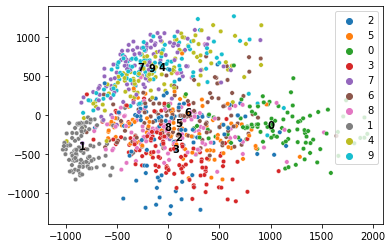

In [ ]:
b.plot()

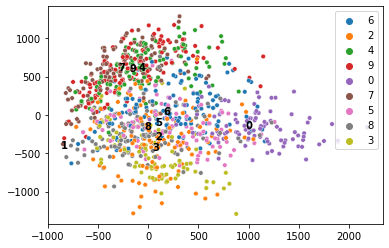

In [ ]:
b.plot(X=X_test_shift_no_1s, y=y_test_shift_no_1s)


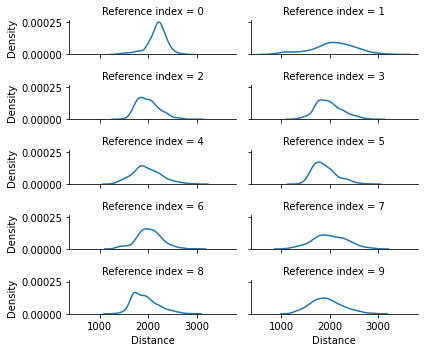

In [ ]:
b.plot_reference_distances()

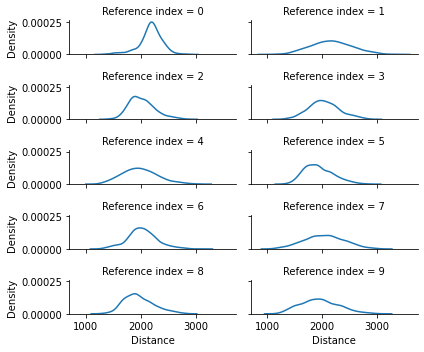

In [ ]:
b.plot_reference_distances(X=X_test_shift_no_1s)

[Text(0, 0.5, 'Closest count'), Text(0.5, 0, 'Reference index')]

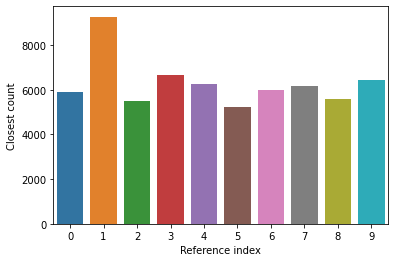

In [ ]:
b.plot_closest_references()

In [ ]:
b.plot_closest_references(X=X_test_shift_no_1s, y=y_test_shift_no_1s)

In [ ]:
b.plot_closest_references_by_label()

In [ ]:
{|"bel(X=X_test_shift_no_1s, y=y_test_shift_no_1s)

In [ ]:
a = EmbeddingsAnalysis(X, y, reference_selector=PCACentroids(n_components=20))

In [ ]:
a.plot()

In [ ]:
a.plot_closest_references_by_label()

In [ ]:
a.plot_reference_distances()

In [ ]:
np.flip(np.array([[1, 2, 3, 4], [5, 6, 7, 8]]), axis=1)

In [ ]:
np.array([[1, 2, 3, 4], [5, 6, 7, 8]]).shape

In [ ]:
EmbeddingsAnalysis.distance_fns["euclidean"](X_test_shift_no_9s, X_test[:5, :])

In [ ]:
EmbeddingsAnalysis.distance_fns["euclidean"](X_test, X_test[:5, :])